# Support Vector Machines

In this repository we will implement linear/kernelized and hard/soft margin SVM variants using both primal and dual QP formulations. We will then utilize Gurobi to optimize the formulations and predict bike inpatient/outpatient status from repairs on the Rice Bikes transaction dataset. 

# 0. Data & Imports

In [33]:
import numpy as np
import pandas as pd

import gurobipy as gp
from gurobipy import GRB 

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [16]:
df = pd.read_csv("../../data/rb_tx_data.csv")
df = df.set_index("TransactionID")

df = df.replace(np.nan,0)

df = df.loc[(df['TotalCost']>0) & 
            (df['RepairCost']>0) &
            (df['TurnaroundTime']>0) &
            (df['TurnaroundTime']<38) # corresponds to two weeks
]

X = df.loc[:, df.columns[14:]].values
y = np.where(df['DayCreated']== df['DayCompleted'], 0, 1)


min_max_scaler = StandardScaler()
X = min_max_scaler.fit_transform(X)

# we apply train_test_split twice to get train, test, val
# the result is 0.7 train, 0.15 each test/ val
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y, test_size=0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state = 42)


## 1 Hard Margin Linear SVM Classifier

First, we will try a hard margin linear SVM to see if our feature data is linearly seperable by inpatient/outpatient class

In [6]:
def hard_margin_linear_SVM(X, y):
    """
    A QP implementation of the linear hard margin SVM
    
    Parameters:
     - X is a (samples x features) data matrix
     - y is a (samples x 1 ) label matrix in {0,1}^{samples} 
    """

    # samples, features
    m,n = X.shape

    # Convert binary labels into positive/negative labels
    t = np.where(y == 0, -1, 1)

    model = gp.Model()

    # weights of hyperplane
    w = model.addMVar(
        lb = float('-inf'),
        ub = float('inf'),
        vtype= GRB.CONTINUOUS,
        shape = n,
        name="w"
    )

    # bias of hyperplane
    b = model.addVar(
        lb = float('-inf'),
        ub = float('inf'),
        vtype = GRB.CONTINUOUS,
        name = "b"
    )

    coeff = 0.5 * np.eye(n)
    model.setObjective(  w @ coeff @ w, GRB.MINIMIZE)
    
    model.addConstrs(t[i] * (w @ X[i, :] + b) >= 1 for i in range(m) )
    
    model.update()
    model.optimize()
    return w.X, b.X

In [7]:
def predict(X, w, b):
    """
    Predict the samples of the given data matrix under
    the linear coeffcients provided by a SVM formulation
    """
    z=  X@w + b
    return np.where(z < 0, 0, 1)

In [8]:
hard_margin_linear_SVM(X_train,y_train)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-23
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1150 rows, 71 columns and 70150 nonzeros
Model fingerprint: 0x3b14705b
Model has 70 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-02, 4e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2 rows and 10 columns
Presolve time: 0.03s

Barrier solved model in 0 iterations and 0.03 seconds (0.01 work units)
Model is infeasible or unbounded


GurobiError: Unable to retrieve attribute 'X'

As the hard margin SVM model is infeasible, we know that our repair data is not linearly seperable by inpatient/outpatient repair class.

## 2. Soft Margin Linear SVM

Instead, we try a more flexible model in the soft margin linear SVM

In [9]:
def soft_margin_linear_SVM(X, y, C=0.5):
    """
    A QP implementation of the linear hard margin SVM
    
    Parameters:
     - X is a (samples x features) data matrix
     - y is a (samples x 1 ) label matrix in {0,1}^{samples} 
     - C is a regularization paramter which penalizes margin violations
    """

    # samples features
    m,n = X.shape


    # Convert binary labels into positive/negative labels
    t = np.where(y == 0, -1, 1)

    model = gp.Model()

    # weights of hyperplane
    w = model.addMVar(
        lb = float('-inf'),
        ub = float('inf'),
        vtype= GRB.CONTINUOUS,
        shape = n,
        name="w"
    )
    
    # one slack variable for each sample
    z = model.addMVar(
        lb = 0, # enforce zeta >= 0 
        ub = float('inf'),
        vtype= GRB.CONTINUOUS,
        shape = m,
        name="z"
    )
    
    # bias of hyperplane
    b = model.addVar(
        lb = float('-inf'),
        ub = float('inf'),
        vtype = GRB.CONTINUOUS,
        name = "b"
    )

    coeff_w = 0.5 * np.eye(n)
    coeff_z = C * np.ones(m)
    model.setObjective(  w @ coeff_w @ w + coeff_z @ z, GRB.MINIMIZE)
    
    model.addConstrs(z[i]+ t[i] * (w @ X[i, :] + b) >=1 for i in range(m) )
    
    model.update()
    model.optimize()
    return w.X, b.X, z.X

Let's try to find the regularization parameter which maximizes validation accuracy:

In [10]:
params = np.linspace(0.001,1, 5)
accuracies = []

for c in params:
    w, b,z  = soft_margin_linear_SVM(X_train,y_train, C=c)
    print(z)
    y_pred = predict(X_val, w, b)
    accuracy_c = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy_c)
    


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1150 rows, 1221 columns and 71300 nonzeros
Model fingerprint: 0xeb6a0845
Model has 70 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-02, 4e+01]
  Objective range  [1e-03, 1e-03]
  QObjective range [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 10 columns
Presolve time: 0.08s
Presolved: 1150 rows, 1211 columns, 71300 nonzeros
Presolved model has 60 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 61
 Free vars  : 61
 AA' NZ     : 7.015e+04
 Factor NZ  : 8.639e+04 (roughly 2 MB of memory)
 Factor Ops : 6.342e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   8.15357491e+03 -2.039

params[np.argmax(accuracies)] = 0.25075


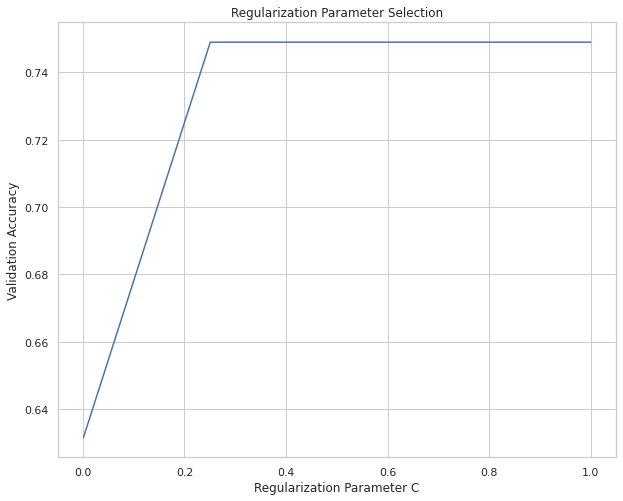

In [14]:
print(f"{params[np.argmax(accuracies)] = }")
sns.set(style="whitegrid")
plt.figure(figsize= (10,8))
plt.plot(params, accuracies)
plt.xlabel("Regularization Parameter C")
plt.ylabel("Validation Accuracy")
plt.title("Regularization Parameter Selection")
plt.show()


    

Let's try to train a soft margin linear SVM using this regularization parameter to predict on the test set:

In [15]:
w, b,z  = soft_margin_linear_SVM(X_train,y_train, C=0.5)
y_pred = predict(X_test, w,b)
accuracy_score(y_test, y_pred)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1150 rows, 1221 columns and 71300 nonzeros
Model fingerprint: 0xd939006c
Model has 70 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-02, 4e+01]
  Objective range  [5e-01, 5e-01]
  QObjective range [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 10 columns
Presolve time: 0.02s
Presolved: 1150 rows, 1211 columns, 71300 nonzeros
Presolved model has 60 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 61
 Free vars  : 61
 AA' NZ     : 7.015e+04
 Factor NZ  : 8.639e+04 (roughly 2 MB of memory)
 Factor Ops : 6.342e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.07678746e+06 -2.039

0.7813765182186235

78% accuracy is very good for this test set!

## 3. Dual (Kernelized) SVM Formulation

Finally to support Kernelized SVM and try our hand at a more complex formulation, we implement the dual formulation

Please note that the assumed row/column order for parameters of the following kernel functions may appear obtuse at first. However, it was carefully chosen to maintain backwards compatibility with what we all think of as a linear kernel, and so that all kernel functions support column vectors as well as broadcasted data matrices.

In [20]:
def kernel_linear(a,b):
    """
    Explicit implemention of the linear kernel we have been using
    """
    return a.T @ b

In [21]:
def kernel_polynomial(a,b,d=2):
    """
    An implementation of a polynomial kernel
    """
    return (a.T @ b) ** d

In [22]:
def kernel_rbf(a, b, gamma=5):
    """
    Implementation of the gaussian RBF kernel.
    Since the kernel contains the sum of inputs, we cannot exploit
    matrix multication for all combinations of inputs
    """
    if a.shape == b.shape:
        # if arguments are the same shape, can use fast np operations
        return np.exp( -1* gamma * np.sqrt( (a-b).T @ (a-b) ) )
    
    # convert to column vectors
    if len(a.shape) ==1:
        a = a.reshape(-1,1)
    if len(b.shape) ==1:
        b = b.reshape(-1,1)
    
    left, inner_a = a.T.shape
    inner_b, right = b.shape
    if inner_a != inner_b:
        # ensure shapes are compatible for comparison
        # equivalent to compatibility for matrix multiplicatoin
        raise ValueError(f"Matrix A.T ({a.T.shape}) incompatible with matrix B ({b.shape})")
    else:
        # build the pairwise dot product matrix of each row / column in a / b
        # might be a faster way to do this with matmul but thinking about it hurts my brain
        C = np.empty((left, right), dtype=float)
        for i, a_i in enumerate(a.T):
            for j, b_j in enumerate(b.T): # we transpose b to get each column
                C[i,j] = (a_i - b_j).T @ (a_i - b_j)
            
        
        return np.exp( -1* gamma * np.sqrt( C ) )
    
        

In [26]:
class DualSVM(object):
    
    def __init__(self, X, y, K = kernel_linear, C=100, **kwargs):
        self.X = X
        self.y = y
        self.K = lambda a,b: K(a, b, **kwargs) # keyword args are passed along to kernel
        self.C = C
        
        self.t = np.where(self.y == 0, -1, 1)
        
        self.solve_alpha_hat_QP()
        
    def solve_alpha_hat_QP(self):
        """
        Solve the quadratic programming dual to get alpha \in R^m
        where alpha_i \neq 0 \iff sample i is a support vector 
        """
        
        # m samples
        # n features
        m,n = self.X.shape
        

        model = gp.Model()

        alpha = model.addMVar(
            lb = 0, # alpha non negative
            ub = self.C,
            vtype= GRB.CONTINUOUS,
            shape = m,
            name="alpha"
        )

        # X.T is (n x m) => K(X.T, X.T) is (m x m)
        _K = self.K(self.X.T, self.X.T)
        print(f"{_K.shape = }")
        H = .5* np.diag(self.t) @ _K @ np.diag(self.t) 
        model.setObjective(alpha @ H @ alpha - np.ones(m)@alpha, GRB.MINIMIZE)

        # a constraint found in the dual formulation of some literature
        model.addConstr( alpha @ self.t == 0)

        model.update()
        model.optimize()
        
        self.alpha_hat = alpha.X
        
        
    def predict(self, X_pred):
        
        
        # indices where alpha_i \neq 0 => x_i is a support vector
        support_mask = np.flatnonzero(self.alpha_hat)
        
        # filter to support vectors
        alpha_S = self.alpha_hat[support_mask]
        t_S = self.t[support_mask]
        X_S = self.X[support_mask, :]
        
 
        # count of support vectors
        n_S = len(alpha_S)
        
        
        b_hat = sum(t_S[i] - alpha_S.T @ np.diag(t_S) @ self.K(X_S.T, X_S[i].T) for i in support_mask)/ n_S
        h = alpha_S.T @ np.diag(t_S) @ self.K(X_S.T, X_pred.T) + b_hat
        #h = A_S.T @ np.diag(t_S) @ np.array(self.K(X_S.T[i]), X_pred.T
        
        return np.where(h < 0, 0, 1)

In [53]:
params = np.linspace(0,0.4, 20)
accuracies = []

for gamma in tqdm(params):
    svm = DualSVM(X_train, y_train, C=0.5, K=kernel_rbf, gamma=gamma)
    y_pred = svm.predict(X_val)
    accuracy_gamma = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy_gamma)
    


  0%|          | 0/20 [00:00<?, ?it/s]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.07s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

  5%|▌         | 1/20 [00:20<06:24, 20.23s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.07s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 10%|█         | 2/20 [00:40<06:05, 20.30s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.08s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 15%|█▌        | 3/20 [01:04<06:14, 22.03s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.09s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 20%|██        | 4/20 [01:28<06:06, 22.94s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.09s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 25%|██▌       | 5/20 [01:57<06:12, 24.86s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.10s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 30%|███       | 6/20 [02:23<05:52, 25.20s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.15s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 35%|███▌      | 7/20 [02:45<05:16, 24.31s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.09s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 40%|████      | 8/20 [03:08<04:45, 23.75s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.09s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 45%|████▌     | 9/20 [03:30<04:17, 23.40s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.08s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 50%|█████     | 10/20 [03:53<03:52, 23.26s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.09s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 55%|█████▌    | 11/20 [04:19<03:36, 24.02s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.10s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 60%|██████    | 12/20 [04:48<03:24, 25.54s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.10s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 65%|██████▌   | 13/20 [05:14<03:00, 25.76s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.08s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 70%|███████   | 14/20 [05:37<02:28, 24.72s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.08s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 75%|███████▌  | 15/20 [05:58<01:58, 23.75s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.09s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 80%|████████  | 16/20 [06:20<01:32, 23.08s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.09s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 85%|████████▌ | 17/20 [06:44<01:10, 23.58s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.10s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 90%|█████████ | 18/20 [07:13<00:50, 25.23s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.09s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

 95%|█████████▌| 19/20 [07:42<00:26, 26.32s/it]

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.10s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

100%|██████████| 20/20 [08:09<00:00, 24.47s/it]


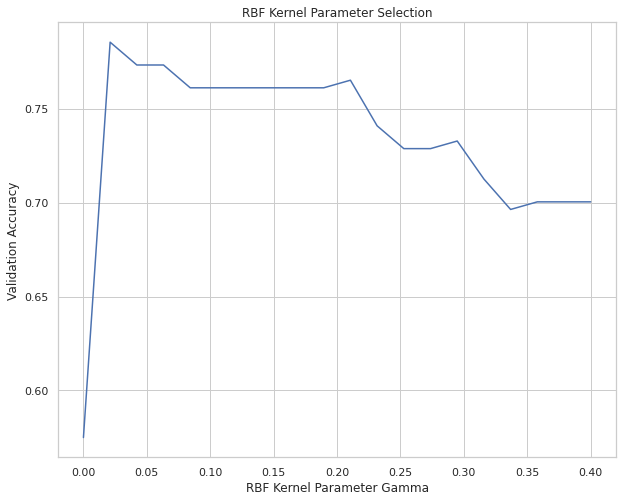

In [54]:
    

plt.figure(figsize= (10,8))
plt.plot(params, accuracies)
plt.ylabel("Validation Accuracy")
plt.xlabel("RBF Kernel Parameter Gamma")
plt.title("RBF Kernel Parameter Selection")
plt.show()


    

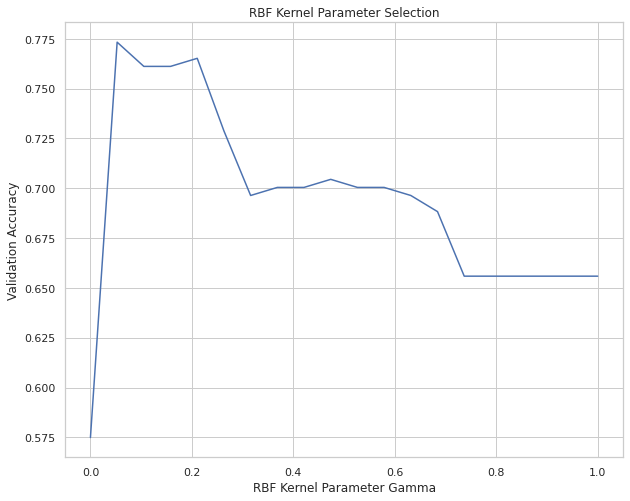

In [41]:
    

plt.figure(figsize= (10,8))
plt.plot(params, accuracies)
plt.ylabel("Validation Accuracy")
plt.xlabel("RBF Kernel Parameter Gamma")
plt.title("RBF Kernel Parameter Selection")
plt.show()


    

In [55]:
params[np.argmax(accuracies)]

0.021052631578947368

In [60]:
svm = DualSVM(X_train, y_train, C= 0.5, K = kernel_rbf, gamma = params[np.argmax(accuracies)]/2)

_K.shape = (1150, 1150)
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1150 columns and 1150 nonzeros
Model fingerprint: 0xbd0410cc
Model has 661825 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.08s
Presolved: 1 rows, 1150 columns, 1150 nonzeros
Presolved model has 661825 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.15025578e+06 -5.75287500e+05  3.82e+05 0.00e+00  1.00e+06     0s
   1  -1.214

In [61]:
y_pred = svm.predict(X_test)

In [62]:
accuracy_score(y_test, y_pred)

0.6923076923076923